## First benchmark

To benchmark: estimating disassembly indexes for increasing levels of complex peptidomes

Do this for 2 proteins, one small (100 aa) and one large (500 aa):
    - For each enzyme:
        - Generate 10 peptidomes
        - Compute DI for peptidomes
        

In [27]:
from disassembly.simulate_proteolysis import enzyme_set, enzyme, amino_acids


enzymes1 = enzyme_set(
    [
        enzyme({"K": 1}, "K protease"),
    ],
    [1],
    [1],
)

enzymes2 = enzyme_set(
    [
        enzyme({"K": 0.5, "R": 0.5}, "K+R protease"),
    ],
    [1],
    [1],
)


enzymes3 = enzyme_set(
    [
        enzyme({"V": 0.3, "I": 0.3, "A": 0.2, "T": 0.1}, "V+I+A+T protease"),
    ],
    [1],
    [1],
)

random = enzyme_set(
    [
        enzyme({aa: 1 / len(amino_acids) for aa in amino_acids.values()}, "random")],
    [1],
    [1],
)

In [28]:
protein = "MAHVRGLQLPGCLALAALCSLVHSQHVFLAPQQARSLLQRVRRANTFLEEVRKGNLERECVEETCSYEEAFEALESSTATDVFWAKYTACETARTPRDKLAACLEGNCAEGLGTNYRGHVNITRSGIECQLWRSRYPHKPEINSTTHPGADLQENFCRNPDSSTTGPWCYTTDPTVRRQECSIPVCGQDQVTVAMTPRSEGSSVNLSPPLEQCVPDRGQQYQGRLAVTTHGLPCLAWASAQAKALSKHQDFNSAVQLVENFCRNPDGDEEGVWCYVAGKPGDFGYCDLNYCEEAVEEETGDGLDEDSDRAIEGRTATSEYQTFFNPRTFGSGEADCGLRPLFEKKSLEDKTERELLESYIDGRIVEGSDAEIGMSPWQVMLFRKSPQELLCGASLISDRWVLTAAHCLLYPPWDKNFTENDLLVRIGKHSRTRYERNIEKISMLEKIYIHPRYNWRENLDRDIALMKLKKPVAFSDYIHPVCLPDRETAASLLQAGYKGRVTGWGNLKETWTANVGKGQPSVLQVVNLPIVERPVCKDSTRIRITDNMFCAGYKPDEGKRGDACEGDSGGPFVMKSPFNNRWYQMGIVSWGEGCDRDGKYGFYTHVFRLKKWIQKVIDQFGE"

In [ ]:
from disassembly.simulate_proteolysis import simulate_proteolysis
from disassembly.estimate_weights import estimate_weights
from disassembly.disassembly import (
    get_disassembly,
    get_disassembly_indexes,
    get_disassembly_indexes_mc,
)

results = {}
test_names = ["simple", "medium", "complex", "random"]
iterations = 10
simulated_peptidomes = {}
simulated_graphs = {}
generated_graphs = {}

for test_name, enzymes in zip(test_names, [enzymes1, enzymes2, enzymes3, random]):
    results[test_name] = {}
    simulated_peptidomes[test_name] = {}
    simulated_graphs[test_name] = {}
    generated_graphs[test_name] = {}
    for iteration in range(iterations):
        results[test_name][iteration] = {}
        print(f"Running {test_name} {iteration}")
        simulated_peptidome, simulated_graph = simulate_proteolysis(
            protein,
            enzymes,
            n_start=10,
            n_generate=250,
            endo_or_exo_probability=[0.9, 0.1],
        )
        simulated_peptidomes[test_name][iteration] = simulated_peptidome
        simulated_graphs[test_name][iteration] = simulated_graph
        G, kls, generated, weights = estimate_weights(
            P=simulated_peptidome,
            meta_enzyme=enzymes.meta_enzyme,
            exo_mult_factor=2,
            lr=5,
            n_iterations=1000,
            N_T=1000,
            alpha=0.05,
        )
        generated_graphs[test_name][iteration] = G
        results[test_name][iteration]["kl"] = kls
        results[test_name][iteration]["rdi"] = get_disassembly_indexes(simulated_graph)
        results[test_name][iteration]["rd"] = get_disassembly(
            simulated_peptidome, results[test_name][iteration]["rdi"]
        )
        results[test_name][iteration]["edi"] = get_disassembly_indexes_mc(G, 10000)
        results[test_name][iteration]["ed"] = get_disassembly(
            simulated_peptidome, results[test_name][iteration]["edi"]
        )

/var/folders/64/ytcycnwx6w936vfxs5_7q3hm0000gn/T/ipykernel_5672/3867980253.py:41: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  a, _, _, _ = np.linalg.lstsq(x, e_di)


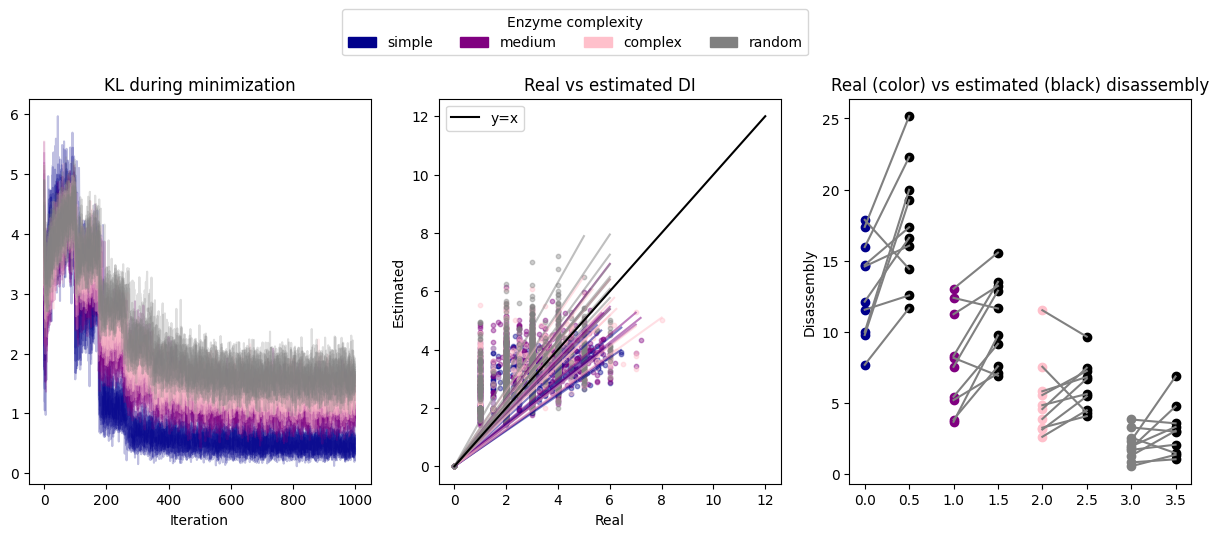

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


def get_nrmse(true, observed):
    true = np.array(true)
    observed = np.array(observed)
    rmse = np.sqrt(np.mean((true - observed) ** 2))
    nrmse = rmse / np.mean(true)
    return nrmse


# Plotting KL-div
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
colors = ["darkblue", "purple", "pink", "gray"]

for i, test_name in enumerate(test_names):
    for iteration in range(iterations):
        axs[0].plot(
            results[test_name][iteration]["kl"],
            label=test_name,
            c=colors[i],
            alpha=0.25,
        )

# plotting corr DI
nrmse = {}
for i, test_name in enumerate(test_names):
    nrmse[test_name] = {}
    for iteration in range(iterations):
        real_di = results[test_name][iteration]["rdi"]
        estimated_di = results[test_name][iteration]["edi"]

        r_di = []
        e_di = []
        for sequence in real_di.keys():
            r_di.append(real_di[sequence])
            e_di.append(estimated_di[sequence])

        x = np.array(r_di)[:, np.newaxis]
        a, _, _, _ = np.linalg.lstsq(x, e_di)

        axs[1].plot(
            np.linspace(0, max(r_di)),
            np.linspace(0, max(e_di)) * a,
            color=colors[i],
            alpha=0.5,
        )
        axs[1].scatter(r_di, e_di, c=colors[i], alpha=0.4, s=10)
        nrmse[test_name][iteration] = get_nrmse(r_di, e_di)

axs[1].plot(np.linspace(0, 12, 100), np.linspace(0, 12, 100), "black", label="y=x")
axs[1].legend()

# plotting real vs estimated disassembly
for i, test_name in enumerate(test_names):
    for iteration in range(iterations):
        real_d = results[test_name][iteration]["rd"]
        estimated_d = results[test_name][iteration]["ed"]

        axs[2].scatter(test_names.index(test_name), real_d, color=colors[i])
        axs[2].scatter(
            test_names.index(test_name) + 0.5,
            estimated_d,
            color="black",
        )
        axs[2].plot(
            [test_names.index(test_name), test_names.index(test_name) + 0.5],
            [real_d, estimated_d],
            color="gray",
        )

#axs[2].set_yscale("log")

axs[0].set_title("KL during minimization")
axs[0].set_xlabel("Iteration")
axs[1].set_title("Real vs estimated DI")
axs[1].set_xlabel("Real")
axs[1].set_ylabel("Estimated")
axs[2].set_title("Real (color) vs estimated (black) disassembly")
axs[2].set_ylabel("Disassembly")

import matplotlib.patches as mpatches

patches = []
for test_name, color in zip(test_names, colors):
    patches.append(mpatches.Patch(color=color, label=test_name))

plt.legend(
    handles=patches,
    bbox_to_anchor=(-0.1, 1.25),
    ncol=4,
    title="Enzyme complexity",
)

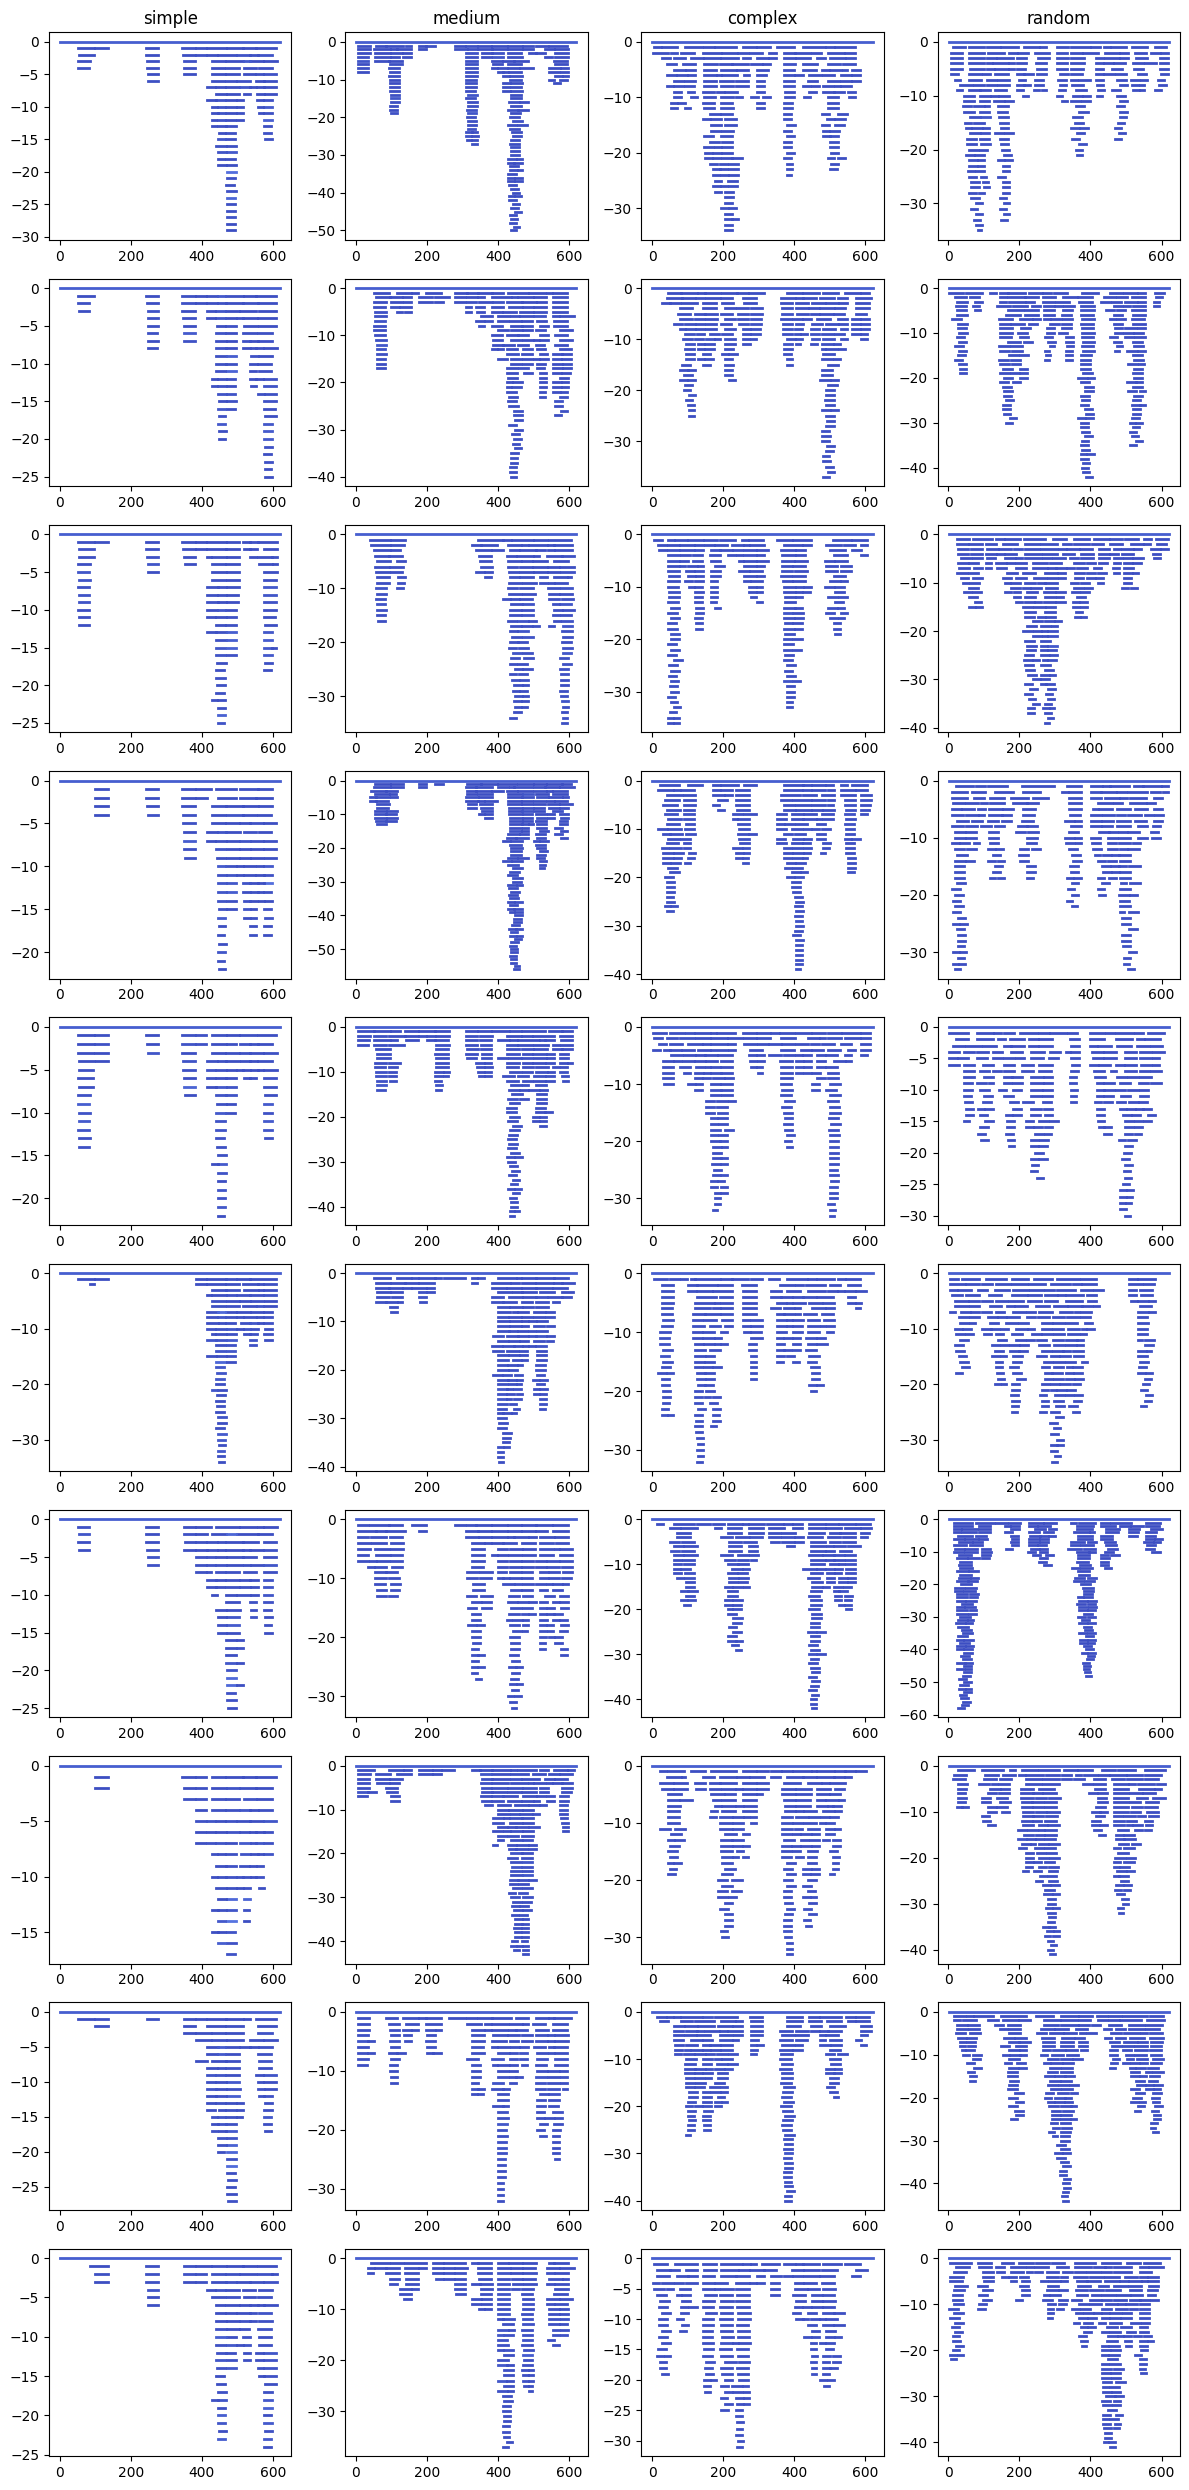

In [ ]:
from disassembly.util import plot_peptidome

fig, axs = plt.subplots(
    iterations, len(test_names), figsize=(len(test_names) * 3, iterations * 2.5)
)
for iteration in range(iterations):
    for test_name in test_names:
        ax = axs[iteration, test_names.index(test_name)]
        if iteration == 0:
            ax.set_title(test_name)
        plot_peptidome(protein, simulated_peptidomes[test_name][iteration], ax)
plt.tight_layout()